# Efficient Grammar Fuzzing

In the [chapter on grammars](Grammars.ipynb), we have seen how to use _grammars_ for very effective and efficient testing.  In this chapter, we refine the previous string-based algorithm into a tree-based algorithm, which is much faster and allows for much more control over the production of fuzz inputs.

**Prerequisites**

* You should know how grammar-based fuzzing works, e.g. from the [chapter on grammars](Grammars.ipynb).

## A More Efficient Algorithm

While simple and straight-forward, our grammar production algorithm from the [previous chapter](Grammars.ipynb) suffers from two problems:

1. *It is inefficient*.  With each iteration, this fuzzer would go search the string produced so far for symbols to expand.  This becomes inefficient as the production string grows.

2. *It is hard to control.*  Even while limiting the number of symbols, it is still possible to obtain very long strings.

Let us illustrate both problems by plotting the time required for strings of different lengths.

In [1]:
import fuzzingbook_utils

In [2]:
from Grammars import simple_grammar_fuzzer
from Grammars import START_SYMBOL, EXPR_GRAMMAR, URL_GRAMMAR, CGI_GRAMMAR
from Grammars import RE_NONTERMINAL, nonterminals, is_nonterminal

In [3]:
from Timer import Timer

In [4]:
trials = 100
xs = []
ys = []
for i in range(trials):
    with Timer() as t:
        s = simple_grammar_fuzzer(EXPR_GRAMMAR, max_nonterminals=15)
    xs.append(len(s))
    ys.append(t.elapsed_time())
    print(i, end=" ")
    
average_time = sum(ys) / trials
print()
print("Average time:", average_time)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
Average time: 0.23473725743991963


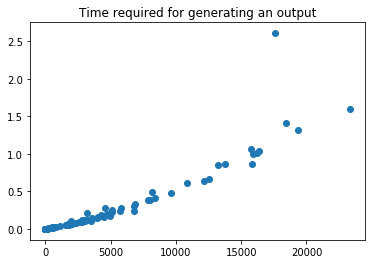

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.title('Time required for generating an output');

We see that (1) the effort increases quadratically over time, and (2) we can easily produce outputs that are tens of thousands of characters long.

## Derivation Trees

To both obtain a more efficient algorithm _and_ exercise better control over expansions, we will use a special representation for the strings that our grammar produces.  The general idea is to use a _tree_ structure that will be subsequently expanded – a so-called _derivation tree_.

Like other trees used in programming, a derivation tree consists of _nodes_ which have other nodes as their _children_.  The tree starts with one node that has no parent; this is called the _root node_; a node without children is called a _leaf_.

The grammar expansion process with derivation trees is illustrated in the following steps, using the arithmetic grammar [from
the chapter on grammars](Grammars.ipynb).  We start with a single node as root of the tree, representing the _start symbol_ – in our case `<start>`.

(We use `dot` as a drawing program; you don't need to look at the code, just at its results.)

In [6]:
from graphviz import Digraph

In [7]:
tree = Digraph("root")
tree.attr('node', shape='plain')
tree.node(r"\<start\>")

In [8]:
tree

To expand the tree, we traverse it, searching for a symbol $S$ without children to expand, and chose an expansion for $S$ from the grammar.  Then, we add the expansion as a new child of $S$.  In the case of our start symbol `<start>`, its only expansion is `<expr>`, so we add this as a child.

In [9]:
tree.edge(r"\<start\>", r"\<expr\>")

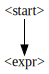

In [10]:
tree

To construct the produced string from a derivation tree, we traverse the tree in order and collect the symbols at the leaves of the tree.  In the case above, we obtain the string `"<expr>"`.

To further expand the tree, we choose another symbol to expand, and add its expansion as new children.  This would get us the `<expr>` symbol, which gets expanded into `<expr> + <term>`, adding three children.

In [11]:
tree.edge(r"\<expr\>", r"\<expr\> ")
tree.edge(r"\<expr\>", r"+")
tree.edge(r"\<expr\>", r"\<term\>")

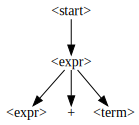

In [12]:
tree

We repeat the expansion until there are no symbols left to expand:

In [13]:
tree.edge(r"\<expr\> ", r"\<term\> ")
tree.edge(r"\<term\> ", r"\<factor\> ")
tree.edge(r"\<factor\> ", r"\<integer\> ")
tree.edge(r"\<integer\> ", r"\<digit\> ")
tree.edge(r"\<digit\> ", r"2 ")

tree.edge(r"\<term\>", r"\<factor\>")
tree.edge(r"\<factor\>", r"\<integer\>")
tree.edge(r"\<integer\>", r"\<digit\>")
tree.edge(r"\<digit\>", r"2")

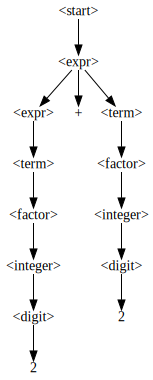

In [14]:
tree

We now have a representation for the string `2 + 2`.  In contrast to the string alone, though, the derivation tree records _the entire structure_ (and production history, or _derivation_ history) of the produced string.  It also allows for simple comparison and manipulation – say, replacing one subtree (substructure) against another.

## Representing Derivation Trees

To represent a derivation tree in Python, we use the following format.  A node is a pair

```python
(SYMBOL_NAME, CHILDREN)
```

where `SYMBOL_NAME` is a string representing the node (i.e. `"<start>"` or `"+"`) and `CHILDREN` is a list of children nodes.

`CHILDREN` can take some special values:

1. `None` as a placeholder for future expansion.  This means that the node is a _nonterminal symbol_ that should be expanded further.
2. `[]` (i.e., the empty list) to indicate _no_ children.  This means that the node is a _terminal symbol_ that can no longer be expanded.

Let us take a very simple derivation tree, representing the intermediate step `<expr> + <term>`, above.

In [15]:
derivation_tree = ("<start>", 
        [("<expr>", 
          [("<expr>", None),
           (" + ", []),
           ("<term>", None)]
         )])

To better understand the structure of this tree, let us introduce a function that visualizes this tree.  We use the `dot` drawing program from the `graphviz` package algorithmically, traversing the above structure.  (Unless you're deeply interested in tree visualization, you can directly skip to the example below.)

In [16]:
from graphviz import Digraph

In [17]:
from IPython.display import display

In [18]:
import re

In [19]:
def dot_escape(s):
    """Return s in a form suitable for dot"""
    # s = s.replace("\\", "\\\\")
    s = re.sub(r"([^a-zA-Z0-9 ])", r"\\\1", s)
    return s

In [20]:
assert dot_escape("hello") == "hello"
assert dot_escape("<hello>, world") == "\\<hello\\>\\, world"
assert dot_escape("\\n") == "\\\\n"

In [21]:
def display_tree(derivation_tree):
    """Visualize a derivation tree as SVG using the graphviz/dot package."""
    
    counter = 0
    def traverse_tree(dot, tree, id=0):
        (symbol, children) = tree
        dot.node(repr(id), dot_escape(symbol))
        
        if children is not None:
            for child in children:
                nonlocal counter  # Assign each node a unique identifier
                counter += 1
                child_id = counter
                dot.edge(repr(id), repr(child_id))
                traverse_tree(dot, child, child_id)

    dot = Digraph(comment="Derivation Tree")
    dot.attr('node', shape='plain')
    traverse_tree(dot, derivation_tree)
    display(dot)

This is what our tree visualizes into:

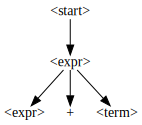

In [22]:
display_tree(derivation_tree)

To turn the tree into a string, the following `all_terminals()` function comes in handy:

In [23]:
def all_terminals(tree):
    (symbol, children) = tree
    if children is None:
        # This is a nonterminal symbol not expanded yet
        return symbol

    if len(children) == 0:
        # This is a terminal symbol
        return symbol

    # This is an expanded symbol:
    # Concatenate all terminal symbols from all children
    return ''.join([all_terminals(c) for c in children])

In [24]:
all_terminals(derivation_tree)

'<expr> + <term>'

## Expanding a Node

Let us now develop an algorithm that takes a tree with unexpanded symbols (say, `derivation_tree`, above), and expands all these symbols one after the other.  As with earlier fuzzers, we create a special subclass of `Fuzzer` – in this case, `GrammarFuzzer`.  A `GrammarFuzzer` gets a grammar and a start symbol; the other parameters will be used later to further control creation and to support debugging.

In [25]:
from Fuzzer import Fuzzer

In [26]:
class GrammarFuzzer(Fuzzer):
    def __init__(self, grammar, start_symbol=START_SYMBOL, 
                 min_nonterminals=0, max_nonterminals=10, disp=False, log=False):
        self.grammar = grammar
        self.start_symbol = start_symbol
        self.min_nonterminals = min_nonterminals
        self.max_nonterminals = max_nonterminals
        self.disp = disp
        self.log = log

In the following, we will add further methods to `GrammarFuzzer`.  The Python language requires us to define an entire class with all methods as a single, continuous unit; however, we would like to introduce one method after another.  To avoid this problem, we use a special hack: Whenever we want to introduce a new method to some class `C`, we use the construct

```python
class C(C):
    def new_method(self, args):
        pass
```

This seems to define `C` as a subclass of itself, which would make no sense – but actually, it introduces a new `C` class as subclass of the old `C` class, and then shadowing the old `C` definition.  What this gets us is a `C` class with `new_method()` as a method, which is just what we want.  (`C` objects defined earlier will retain the earlier `C` definition, though, and thus must be rebuilt.)

Using this hack, let us define a helper method `init_tree()` that constructs a tree with just the start symbol:

In [27]:
class GrammarFuzzer(GrammarFuzzer):
    def init_tree(self):
        return (self.start_symbol, None)

In [28]:
f = GrammarFuzzer(EXPR_GRAMMAR)
display_tree(f.init_tree())

Next, we will need a helper method `expansion_to_children()` that takes an expansion string and converts it into a list of derivation trees.  It uses the `re.split()` method to split an expansion string into a list of children nodes:

In [29]:
class GrammarFuzzer(GrammarFuzzer):
    def expansion_to_children(self, expansion):
        # print("Converting " + repr(expansion))
        # strings contains all substrings -- both terminals and non-terminals such
        # that ''.join(strings) == expansion

        # See nonterminals() in Grammars.py
        if isinstance(expansion, tuple):
            expansion = expansion[0]

        if expansion == "":  # Special case: empty expansion
            return [("", [])]

        strings  = re.split(RE_NONTERMINAL, expansion)
        return [(s, None) if is_nonterminal(s) else (s, []) for s in strings if len(s) > 0]

In [30]:
f = GrammarFuzzer(EXPR_GRAMMAR)
f.expansion_to_children("<term> + <expr>")

[('<term>', None), (' + ', []), ('<expr>', None)]

The case of an empty expansion needs special treatment:

In [31]:
f.expansion_to_children("")

[('', [])]

Just like `nonterminals()` in the [chapter on Grammars](Grammars.ipynb), we provide for future extensions, allowing the expansion to be a tuple with extra data (which will be ignored).

In [32]:
f.expansion_to_children(("+<term>", ["extra_data"]))

[('+', []), ('<term>', None)]

With this, we can now take some unexpanded node in the tree, choose a random expansion, and return the new tree.  This is what the method `expand_node_randomly()` does, using a helper function `choose_node_expansion()` to randomly pick an index from an array of possible children.  (`choose_node_expansion()` can be overloaded in subclasses.)

In [33]:
import random

In [34]:
class GrammarFuzzer(GrammarFuzzer):
    def choose_node_expansion(self, node, possible_children):
        """Return index of expansion in `possible_children` to be selected.  Defaults to random."""
        return random.randrange(0, len(possible_children))

    def expand_node_randomly(self, node):
        (symbol, children) = node
        assert children is None
        
        if self.log:
            print("Expanding", all_terminals(node), "randomly")

        # Fetch the possible expansions from grammar...
        expansions = self.grammar[symbol]
        possible_children = [self.expansion_to_children(expansion) for expansion in expansions]

        # ... and select a random expansion
        index = self.choose_node_expansion(node, possible_children)
        children = possible_children[index]

        # Return with new children
        return (symbol, children)

The generic `expand_node()` method can later be used to select different expansion strategies; as of now, it only uses `expand_node_randomly()`.

In [35]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node(self, node):
        return self.expand_node_randomly(node)

This is how `expand_node_randomly()` works:

Before:


After:
Expanding <term> randomly


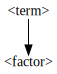

In [36]:
f = GrammarFuzzer(EXPR_GRAMMAR, log=True)

print("Before:")
tree = ("<term>", None)
display_tree(tree)

print("After:")
tree = f.expand_node_randomly(tree)
display_tree(tree)

## Expanding a Tree

Let us now apply the above node expansion to some node in the tree.  To this end, we first need to search the tree for unexpanded nodes.  `possible_expansions()` counts how many unexpanded symbols there are in a tree:

In [37]:
class GrammarFuzzer(GrammarFuzzer):
    def possible_expansions(self, node):
        (symbol, children) = node
        if children is None:
            return 1

        number_of_expansions = sum(self.possible_expansions(c) for c in children)
        return number_of_expansions

In [38]:
f = GrammarFuzzer(EXPR_GRAMMAR)
print(f.possible_expansions(derivation_tree))

2


`any_possible_expansions()` returns True if the tree has any unexpanded nodes.

In [39]:
class GrammarFuzzer(GrammarFuzzer):
    def any_possible_expansions(self, node):
        (symbol, children) = node
        if children is None:
            return True

        return any(self.any_possible_expansions(c) for c in children)

In [40]:
f = GrammarFuzzer(EXPR_GRAMMAR)
f.any_possible_expansions(derivation_tree)

True

Here comes `expand_tree_once()`, the core method of our tree expansion algorithm.  It first checks whether it is currently being applied on a nonterminal symbol without expansion; if so, it invokes `expand_node()` on it as above.  

If the node is already expanded (i.e. has children), it checks the subset of children which still have unexpanded symbols; randomly selects one of them, and applies itself recursively on that child.

The `expand_tree_once()` method replaces the child _in place_, meaning that it actually mutates the tree being passed as an argument rather than returning a new tree.  This in-place mutation is what makes this function particularly efficient.  Again, we use a helper method (`choose_tree_expansion()`) to return the chosen index from a list of children that can be expanded.

In [41]:
class GrammarFuzzer(GrammarFuzzer):
    def choose_tree_expansion(self, tree, children):
        """Return index of subtree in `children` to be selected for expansion.  Defaults to random."""
        return random.randrange(0, len(children))

    def expand_tree_once(self, tree):
        # print("Expanding " + repr(tree))

        (symbol, children) = tree
        if children is None:
            # Expand this node
            return self.expand_node(tree)

        # Find all children with possible expansions
        expandable_children = [c for c in children if self.any_possible_expansions(c)]
        
        # `index_map` translates an index in `expandable_children` back into the original index in `children`
        index_map = [i for (i, c) in enumerate(children) if self.any_possible_expansions(c)]
        
        # print("expandable_children =", expandable_children)
        # print("index_map =", index_map)

        # Select a random child
        child_to_be_expanded = self.choose_tree_expansion(tree, expandable_children)
        
        # Expand in place
        children[index_map[child_to_be_expanded]] = \
            self.expand_tree_once(expandable_children[child_to_be_expanded])

        return tree

Let's put it to use, expanding our derivation tree from above twice.

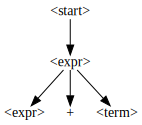

In [42]:
derivation_tree = ("<start>", 
        [("<expr>", 
          [("<expr>", None),
           (" + ", []),
           ("<term>", None)]
         )])
display_tree(derivation_tree)

Expanding <term> randomly


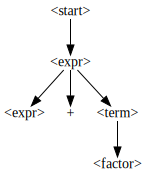

In [43]:
f = GrammarFuzzer(EXPR_GRAMMAR, log=True)
derivation_tree = f.expand_tree_once(derivation_tree)
display_tree(derivation_tree)

Expanding <expr> randomly


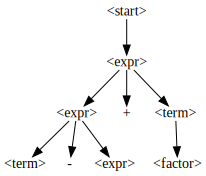

In [44]:
derivation_tree = f.expand_tree_once(derivation_tree)
display_tree(derivation_tree)

We see that which each step, one more symbol is expanded.  Now all it takes is to apply this again and again, expanding the tree further and further.

## Closing the Expansion

With `expand_tree_once()`, we can keep on expanding the tree – but how do we actually stop?  The key idea here, introduced by Luke in \cite{Luke2000}, is that after inflating the derivation tree to some maximum size, we _only want to apply expansions that increase the size of the tree by a minimum_.  For `<factor>`, for instance, we would prefer an expansion into `<integer>`, as this will not introduce further recursion (and potential size inflation); for `<integer>`, likewise, an expansion into `<digit>` is preferred, as it will less increase tree size than `<digit><integer>`.

To identify the _cost_ of expanding a symbol, we introduce two functions that mutually rely on each other.  First, `symbol_cost()` returns the minimum cost of all expansions of a symbol, using `expansion_cost()` to compute the cost for each expansion.

The method `expansion_cost()` returns the sum of all expansions in `expansions`.  If a nonterminal is encountered again during traversal, the cost of the expansion is $\infty$, as this indicates (potential infinite) recursion.

In [45]:
class GrammarFuzzer(GrammarFuzzer):
    def symbol_cost(self, symbol, seen=set()):
        expansions = self.grammar[symbol]
        return min(self.expansion_cost(e, seen | {symbol}) for e in expansions)

    def expansion_cost(self, expansion, seen=set()):
        syms = nonterminals(expansion)
        if len(syms) == 0:
            return 1  # no symbol

        if any(s in seen for s in syms):
            return float('inf')

        # the value of a expansion is the sum of all expandable variables inside + 1
        return sum(self.symbol_cost(s, seen) for s in syms) + 1

Here's two examples: The minimum cost of expanding a digit is 1, since we have to choose between one of its expansions.

In [46]:
f = GrammarFuzzer(EXPR_GRAMMAR)
assert f.symbol_cost("<digit>") == 1

The minimum number of expansions when expanding `<expr>`, though, is five, as this is the minimum number of expansions required.  (`<expr>` → `<term>` → `<factor>` → `<integer>` → `<digit>` → 1)

In [47]:
assert f.symbol_cost("<expr>") == 5

Here's now a variant of `expand_node()` that takes the above cost into account.  It determines the minimum cost `cost` across all children and then chooses a child from the list using the `choose` function, which by default is the minimum cost.  If multiple children all have the same minimum cost, it chooses randomly between these.

In [48]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node_by_cost(self, node, choose=min):
        (symbol, children) = node
        assert children is None

        # Fetch the possible expansions from grammar...
        expansions = self.grammar[symbol]

        possible_children_with_cost = [(self.expansion_to_children(expansion),
                                        self.expansion_cost(expansion, {symbol}))
                                      for expansion in expansions]

        costs = [cost for (child, cost) in possible_children_with_cost]
        chosen_cost = choose(costs)
        children_with_chosen_cost = [child for (child, child_cost) in possible_children_with_cost
                                  if child_cost == chosen_cost]

        children = random.choice(children_with_chosen_cost)

        # Return with a new list
        return (symbol, children)   

The shortcut `expand_node_min_cost()` passes `min()` as the `choose` function, which makes it expand nodes at minimum cost.

In [49]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node_min_cost(self, node):
        if self.log:
            print("Expanding", all_terminals(node), "at minimum cost")

        return self.expand_node_by_cost(node, min)

We can now apply this function to close the expansion of our derivation tree, using `expand_tree_once()` with the above `expand_node_min_cost()` as expansion function.

In [50]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node(self, node):
        return self.expand_node_min_cost(node)

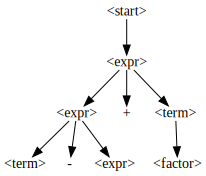

Expanding <factor> at minimum cost


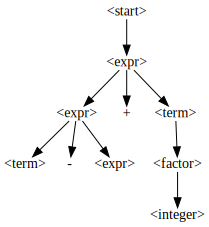

Expanding <term> at minimum cost


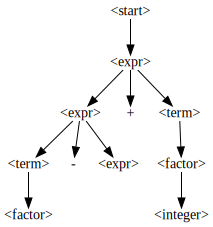

Expanding <integer> at minimum cost
Expanding <digit> at minimum cost
Expanding <factor> at minimum cost
Expanding <integer> at minimum cost
Expanding <digit> at minimum cost
Expanding <expr> at minimum cost
Expanding <term> at minimum cost
Expanding <factor> at minimum cost
Expanding <integer> at minimum cost
Expanding <digit> at minimum cost


In [51]:
f = GrammarFuzzer(EXPR_GRAMMAR, log=True)
display_tree(derivation_tree)

step = 1
while f.any_possible_expansions(derivation_tree):
    derivation_tree = f.expand_tree_once(derivation_tree)
    if step < 3:
        display_tree(derivation_tree)
    step += 1

We see that in each step, `expand_node_min_cost()` chooses an expansion that does not increase the number of symbols, eventually closing all open expansions.

## Node Inflation

Especially at the beginning of an expansion, we may be interested in getting _as many nodes as possible_ – that is, we'd like to prefer expansions that give us _more_ nonterminals to expand.  This is actually the exact opposite from what `expand_node_min_cost()` gives us, and we can implement a method `expand_node_max_cost()` that will always choose among the nodes with the _highest_ cost:

In [52]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node_max_cost(self, node):
        if self.log:
            print("Expanding", all_terminals(node), "at maximum cost")

        return self.expand_node_by_cost(node, max)

To illustrate `expand_node_max_cost()`, we can again redefine `expand_node()` to use it, and then use `expand_tree_once()` to show a few expansion steps:

In [53]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node(self, node):
        return self.expand_node_max_cost(node)

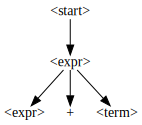

Expanding <expr> at maximum cost


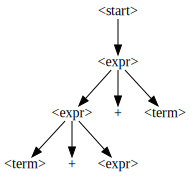

Expanding <expr> at maximum cost


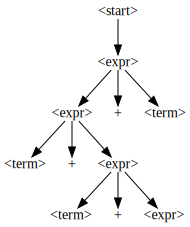

In [54]:
derivation_tree = ("<start>", 
        [("<expr>", 
          [("<expr>", None),
           (" + ", []),
           ("<term>", None)]
         )])

f = GrammarFuzzer(EXPR_GRAMMAR, log=True)
display_tree(derivation_tree)

step = 1
while step < 3 and f.any_possible_expansions(derivation_tree):
    derivation_tree = f.expand_tree_once(derivation_tree)
    display_tree(derivation_tree)
    step += 1

We see that with each step, the number of nonterminals increases.  Obviously, we have to put a limit on this number.

## Three Expansion Phases

We can now put all three phases together in a single function `expand_tree()` which will work as follows:

1. **Max cost expansion.** Expand the tree using expansions with maximum cost until we have at least `min_nonterminals` nonterminals.  This phase can be easily skipped by setting `min_nonterminals` to zero.
2. **Random expansion.**  Keep on expanding the tree randomly until we reach `max_nonterminals` nonterminals.
3. **Min cost expansion.** Close the expansion with minimum cost.

We implement these three phases by having `expand_node` reference the expansion method to apply.  This is controlled by setting `expand_node` (the method reference) to first `expand_node_max_cost` (i.e., calling `expand_node()` invokes `expand_node_max_cost()`), then `expand_node_randomly`, and finally `expand_node_min_cost`.  In the first two phases, we also set a maximum limit of `min_nonterminals` and `max_nonterminals`, respectively.

In [55]:
class GrammarFuzzer(GrammarFuzzer):
    def log_tree(self, tree):
        """Output a tree if self.log is set; if self.display is also set, show the tree structure"""
        if self.log:
            print("Tree:", all_terminals(tree))
            if self.disp:
                display_tree(tree)
            # print(self.possible_expansions(tree), "possible expansion(s) left")

    def expand_tree_with_strategy(self, tree, expand_node_method, limit=None):
        """Expand tree using `expand_node_method` as node expansion function 
        until the number of possible expansions reaches `limit`."""
        self.expand_node = expand_node_method
        while (limit is None or self.possible_expansions(tree) < limit) and self.any_possible_expansions(tree):
            tree = self.expand_tree_once(tree)
            self.log_tree(tree)
        return tree
            
    def expand_tree(self, tree):
        """Expand `tree` in a three-phase strategy until all expansions are complete."""
        self.log_tree(tree)
        tree = self.expand_tree_with_strategy(tree, self.expand_node_max_cost, self.min_nonterminals)
        tree = self.expand_tree_with_strategy(tree, self.expand_node_randomly, self.max_nonterminals)
        tree = self.expand_tree_with_strategy(tree, self.expand_node_min_cost)

        assert self.possible_expansions(tree) == 0

        return tree

Let us try this out on our example.

Tree: <expr> + <term>
Expanding <expr> at maximum cost
Tree: <term> + <expr> + <term>
Expanding <term> randomly
Tree: <factor> / <term> + <expr> + <term>
Expanding <expr> randomly
Tree: <factor> / <term> + <term> - <expr> + <term>
Expanding <term> at minimum cost
Tree: <factor> / <term> + <term> - <expr> + <factor>
Expanding <factor> at minimum cost
Tree: <integer> / <term> + <term> - <expr> + <factor>
Expanding <expr> at minimum cost
Tree: <integer> / <term> + <term> - <term> + <factor>
Expanding <factor> at minimum cost
Tree: <integer> / <term> + <term> - <term> + <integer>
Expanding <integer> at minimum cost
Tree: <integer> / <term> + <term> - <term> + <digit>
Expanding <digit> at minimum cost
Tree: <integer> / <term> + <term> - <term> + 0
Expanding <term> at minimum cost
Tree: <integer> / <factor> + <term> - <term> + 0
Expanding <term> at minimum cost
Tree: <integer> / <factor> + <term> - <factor> + 0
Expanding <factor> at minimum cost
Tree: <integer> / <factor> + <term> - <integer

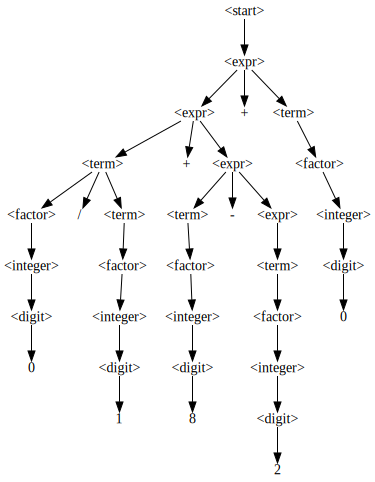

In [56]:
derivation_tree = ("<start>", 
        [("<expr>", 
          [("<expr>", None),
           (" + ", []),
           ("<term>", None)]
         )])

f = GrammarFuzzer(EXPR_GRAMMAR, min_nonterminals=3, max_nonterminals=5, log=True)
derivation_tree = f.expand_tree(derivation_tree)
display_tree(derivation_tree)

In [57]:
all_terminals(derivation_tree)

'0 / 1 + 8 - 2 + 0'

## Putting it all Together

Based on this, we can now define a function `fuzz()` that – like `simple_grammar_fuzzer()` – simply takes a grammar and produces a string from it.  It thus no longer exposes the complexity of derivation trees.

In [58]:
class GrammarFuzzer(GrammarFuzzer):
    def fuzz_tree(self):
        # Create an initial derivation tree
        tree = self.init_tree()
        # print(tree)

        # Expand all nonterminals
        tree = self.expand_tree(tree)
        if self.log:
            print(repr(all_terminals(tree)))
        if self.disp:
            display_tree(tree)
        return tree

    def fuzz(self):
        self.derivation_tree = self.fuzz_tree()
        return all_terminals(self.derivation_tree)

We can now apply this on all our defined grammars (and visualize the derivation tree along)

In [59]:
f = GrammarFuzzer(EXPR_GRAMMAR)
f.fuzz()

'(1) * (5) * 2.4 / 4 + 9.7 / 0 - 0 + 3'

After calling `fuzz()`, the produced derivation tree is accessible in the `derivation_tree` attribute:

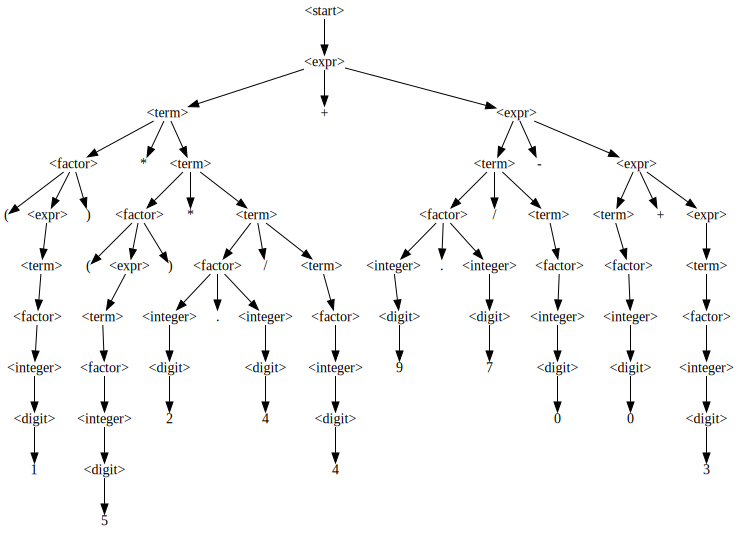

In [60]:
display_tree(f.derivation_tree)

Let us try out the grammar fuzzer (and its trees) on other grammar formats.

In [61]:
f = GrammarFuzzer(URL_GRAMMAR)
f.fuzz()

'ftps://fuzzingbook.com:74'

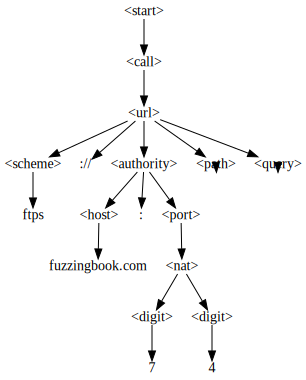

In [62]:
display_tree(f.derivation_tree)

In [63]:
f = GrammarFuzzer(CGI_GRAMMAR, min_nonterminals=3, max_nonterminals=5)
f.fuzz()

'%4d%94+0'

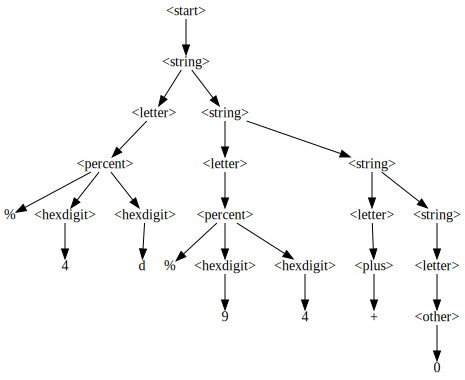

In [64]:
display_tree(f.derivation_tree)

How do we stack up against `simple_grammar_fuzzer()`?

In [65]:
trials = 100
xs = []
ys = []
f = GrammarFuzzer(EXPR_GRAMMAR, max_nonterminals=20)
for i in range(trials):
    with Timer() as t:
        s = f.fuzz()
    xs.append(len(s))
    ys.append(t.elapsed_time())
    print(i, end=" ")

average_time = sum(ys) / trials
print()
print("Average time:", average_time)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
Average time: 0.07048222986973997


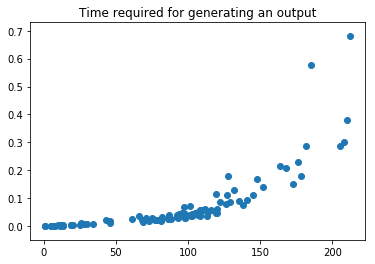

In [66]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.title('Time required for generating an output');

Our test generation is much faster, but also our inputs are much smaller.  \todo{(Actually, parts of the time gain may be due to the faster time.)}  We see that with derivation trees, we can get much better control over grammar production.

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducing.ipynb)


## Exercises

_Close the chapter with a few exercises such that people have things to do.  Use the Jupyter `Exercise2` nbextension to add solutions that can be interactively viewed or hidden.  (Alternatively, just copy the exercise and solution cells below with their metadata.)  We will set up things such that solutions do not appear in the PDF and HTML formats._

### Exercise 1

Speed up things by memoizing.

In [67]:
# cache the function calls. We only cache a given call based on the
# indicated argument number per function.
def memoize(argnum):
    def fn_wrap(function):
        memo = {}
        def wrapper(*args):
            if args[argnum] in memo: return memo[args[argnum]]
            rv = function(*args)
            memo[args[argnum]] = rv
            return rv
        return wrapper
    return fn_wrap

_Solution for the exercise_

### Exercise 2

Speed up things by tracking which children still can be expanded.

_Solution for the exercise_

### Exercise 3

We could define `expand_node_randomly()` such that it simply invokes `expand_node_by_cost(node, random.choice)`:

In [68]:
class ExerciseGrammarFuzzer(GrammarFuzzer):
    def expand_node_randomly(self, node):
        if self.log:
            print("Expanding", all_terminals(node), "randomly by cost")

        return self.expand_node_by_cost(node, random.choice)

What is the difference between the original implementation and this alternative?

_Solution for the exercise_

### Exercise 4

Python 3.7 and later allow the use of _annotations_ to attach Python snippets to arbitrary syntactic elements.  You can make use of such annotations to produce even nicer grammars, using `|` to separate alternatives:

```python
from __future__ import annotations

class expression_grammar:
   start: "<expr>"
   expr: "<term> + <expr>" | "<term> - <expr>"
   term: "<factor> * <term>" | "<factor> / <term>" | "<factor>"
   factor: "+<factor>" | "-<factor>" | "(<expr>)" | "<integer>" | "<integer>.<integer>"
   integer: "<digit> <integer>" | "<digit>"
   digit: '0' | '1' | '2' | '3' | '4' | '5' | '6' | '7' | '8' | '9'
```

The annotation can be accessed using the `__annotations__` attribute:

```python
print(expression_grammar.__annotations__)
{'start': "'<expr>'", 'expr': "'<term> + <expr>' | '<term> - <expr>'", 
 'term': "'<factor> * <term>' | '<factor> / <term>' | '<factor>'", 
 ...}
```

Using Python 3.7 or later, write a converter that takes a grammar class using the above syntax and convert it to the "portable" format described in this chapter.

_Solution for the exercise_